In [1]:
#!pip install -U transformers
#!pip install -U datasets
#!pip install optuna
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
#!pip install transformers
from transformers import RobertaConfig, RobertaModel,RobertaForSequenceClassification, Trainer,AutoModelForSequenceClassification, EarlyStoppingCallback 
from transformers import AutoTokenizer
from transformers.models.roberta import RobertaPreTrainedModel
import torch
from torch import nn
from transformers import TrainingArguments
import glob
import optuna
from itertools import product
import numpy as np
from pprint import pprint
import csv
from transformers import set_seed
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Optional, Set, Tuple, Union
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image

In [2]:
MODEL_NAME =  "distilbert-base-uncased" #"roberta-base" 
TARGET_COL = 'averageRating'#'revenue_worldwide_BOM'
MODEL_FOLDER = 'everything_as_text_and_images'#'everything_as_text'
text_input_col = 'text_input'
CATEGORIES_AS_TEXT = True
NUMERIC_AS_TEXT = True
DATE_AS_TEXT = True
ADJUST_INFLATION = False
USE_COLUMN_NAMES = False
DEBUG = False
IMG_SIZE = 224

FINAL_MODEL_NAME = f"{MODEL_NAME}-{TARGET_COL}"

if ADJUST_INFLATION:
    FINAL_MODEL_NAME+='-inflation_adjusted'
    
if USE_COLUMN_NAMES:
    FINAL_MODEL_NAME+='-with_column_names'
    

FINAL_MODEL_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}'
TRIALS_DF_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_hparams_trials.csv'
TEST_PERFORMANCE_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_test_stats_best_model.csv'
    
if USE_COLUMN_NAMES:
    assert CATEGORIES_AS_TEXT|NUMERIC_AS_TEXT|DATE_AS_TEXT, "can't use column names as text if there are no columns to treat as text!"
    
print('Final model name: ',FINAL_MODEL_NAME)
print('Saving at: ',MODEL_FOLDER)



Final model name:  distilbert-base-uncased-averageRating
Saving at:  everything_as_text_and_images


In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


def read_images_split(split,path = 'data/processed/posters/',id_col="imdb_id"):
  split_images = []
  for row in split:

      name = f'{int(row)}.jpg'

      img_name = os.path.join(path,name)
        
      missing_image = plt.imread(os.path.join(path,'missing.jpg'))
    
      # Use you favourite library to load the image
      try:
        image = plt.imread(img_name)

      except FileNotFoundError:
        image = missing_image
        
      if len(image.shape)==2:
        image = np.repeat(np.expand_dims(image,-1),3,-1)
    
      split_images.append(image.transpose([2,1,0]))
        
  return split_images


class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, transform):
        self.encodings = encodings
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        
        item = {}
        item['labels'] = torch.tensor(self.labels[idx])
        for key, val in self.encodings.items():
            
            if key == 'images':
                item['images'] = Image.fromarray(val[idx].astype(np.uint8).transpose(1,2,0))
                item['images'] = self.transform(item['images'])
            else:
                item[key] = torch.tensor(val[idx])
            
            

        
        return item
    
    def __len__(self):
        return len(self.labels)

def process_text_data(data_:pd.DataFrame,text_col,padding ="max_length", truncation = True, na_filler = ""):

    '''
    
    '''
    data = data_.copy()
    data[text_col] = data[text_col].fillna(na_filler)
    encodings = tokenizer(data[text_col].tolist(), padding=padding, truncation=truncation)
    return encodings
    

def columns_to_single_text(df,
                           cols_to_transform,
                           new_col_name = 'text_input',
                           sep = tokenizer.sep_token,
                           nan_replacement = tokenizer.unk_token ):

  '''
  
  Creates a new column called new_col_name with with all columns in cols_to_transform concatenated into a single text
  '''
  df[new_col_name] = df[cols_to_transform].astype(str).replace('nan',nan_replacement).agg(f' {sep} '.join, axis=1)


class NAFiller:

  def __init__(self,train):
    self.train = train

  def fit(self,column = 'Budget',groupby=['top_genre','top_country']):
    self.mapping = self.train.groupby(groupby)[column].median().reset_index()
    self.mapping = self.mapping.rename(columns={column:'na_filler'})
    self.median = self.train[column].median()
    self.column=column


  def transform(self,test,round = False):
    self.na_filler = test.merge(self.mapping,how='left')['na_filler']
    self.na_filler = self.na_filler.fillna(self.median)

    test[self.column] = test[self.column].reset_index(drop=True).fillna(self.na_filler).values

    if round:
      test[self.column] = test[self.column].round().astype(int)
      


  def fit_transform(self,test,column = 'Budget',groupby=['top_genre','top_country']):
    self.fit(column,groupby)
    self.transform()
    self.column=column
        

def create_dataset_split(split,
                         text_cols,
                         text_input_col,
                         TARGET_COL,
                         transform,
                         numeric_cols = [],
                         images = None,
                         new_col_name = 'text_input',
                         sep = tokenizer.sep_token,
                         nan_replacement = tokenizer.unk_token):
    
  if TARGET_COL == 'revenue_worldwide_BOM':
    split[TARGET_COL] = np.log1p(split[TARGET_COL])
    print('log transforming target')

  #If all columns in text_cols are combined into a single text. A n
  columns_to_single_text(split,text_cols)

  #Get split encodings
  split_encodings = process_text_data(split,text_input_col)
    
  if numeric_cols:
    split_encodings['numeric_features'] = split[numeric_cols].values.tolist()
    
  if images:
    split_encodings['images'] = images
    
    
  #get labels
  split_labels = split[TARGET_COL].tolist()

  #Create dataset objects
  split_dataset = IMDbDataset(split_encodings, split_labels,transform)

  return split_dataset

def date_to_season(doy):
    doy = doy.dayofyear
    # "day of year" ranges for the northern hemisphere
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if doy in spring:
      season = 1 #'spring'
    elif doy in summer:
      season = 2 #'summer'
    elif doy in fall:
      season = 3 #'fall'
    else:
      season = 4 #'winter'
    return season

def cyclical_encoding(data, col, max_val, min_val = 1, drop = True):
    """Encoding of cyclical features using sine and cosine transformation.
    Examples of cyclical features are: hour of day, month, day of week.

    :param df: A dataframe containing the column we want to encode
    :type df: :py:class:`pandas.DataFrame`
    :param col: The name of the column we want to encode.
    :type col: str
    :param max_val: The maximum value the variable can have. e.g. in hour of day, max value = 23
    :type max_val: int
    :param min_val: The minimum value the variable can have. e.g. in hour of day, min value = 1, defaults to 1
    :type min_val: int
    :return: dataframe with three new variables: sine and cosine of the features + the multiplicationof these two columns
    :rtype: :py:class:`pandas.DataFrame`
    """

    data[col] = data[col] - min_val #ensure min value is 0
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)

    if drop:
        data.drop(col,axis=1,inplace=True)


In [4]:
all_cols =  ['Budget',
             'averageRating',
             'cast',
             'countries',
             'director',
             'genres',
             'imdb_id',
             'languages',
             'overview',
             'production companies',
             'release_date',
             'revenue_worldwide_BOM',
             'runtimeMinutes',
             'title']



transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(),
    #transforms.RandomHorizontalFlip(),
    #transforms.CenterCrop(size=IMG_SIZE)
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
    

#Train/test transforms
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
    
    
    
train_ids = pd.read_csv('data/processed/train.csv',usecols=['imdb_id'])['imdb_id'].tolist()
val_ids = pd.read_csv('data/processed/val.csv',usecols=['imdb_id'])['imdb_id'].tolist()
test_ids = pd.read_csv('data/processed/test.csv',usecols=['imdb_id'])['imdb_id'].tolist()
df = pd.read_csv('data/processed/df.csv',usecols = all_cols,parse_dates=['release_date']).sample(frac=1,random_state=42) #shuffle



#Additional auxilary columns
df['top_genre'] = df['genres'].apply(lambda x: x.split(', ')[0])
df['top_country'] = df['countries'].apply(lambda x: x.split(', ')[0] if isinstance(x,str) else x)


categoric_cols = ['cast',
                  'countries',
                  'director',
                  'genres',
                  'languages',
                  'production companies']

text_cols = ['title','overview']                  
date_cols = ['release_date']

if (not DATE_AS_TEXT): #If date is not as text, include numeri date features
    df['year'] = df['release_date'].dt.year
    df['month'] = df['release_date'].dt.month
    df['day'] = df['release_date'].dt.day
    df['season'] = df['release_date'].apply(date_to_season)
    df['dayofweek'] = df['release_date'].dt.dayofweek
    
    
    cyclical_encoding(df, 'month', max_val = 12, min_val = 1, drop = True)
    cyclical_encoding(df, 'day', max_val = 31, min_val = 1, drop = True) #TODO: Not exactly true
    cyclical_encoding(df, 'season', max_val = 4, min_val = 1, drop = True)
    cyclical_encoding(df, 'dayofweek', max_val = 6, min_val = 0, drop = True)



    
df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.replace('|',', '),axis=0) #Change pipe to comma, its more meaningful
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'],errors='coerce')


numeric_cols = list(df.dtypes.index[(df.dtypes == int)|(df.dtypes == float)].drop(['imdb_id',
                                                                              'averageRating',
                                                                              'revenue_worldwide_BOM']))



if CATEGORIES_AS_TEXT:
  text_cols+=categoric_cols

if NUMERIC_AS_TEXT:
  text_cols+=numeric_cols

if DATE_AS_TEXT:
  text_cols+=date_cols



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [5]:
#Create splits
if DEBUG:
    train = df[df['imdb_id'].isin(train_ids)].sample(frac=0.2)
    val = df[df['imdb_id'].isin(val_ids)].sample(frac=0.2)
    test = df[df['imdb_id'].isin(test_ids)]
else:
    train = df[df['imdb_id'].isin(train_ids)]
    val = df[df['imdb_id'].isin(val_ids)]
    test = df[df['imdb_id'].isin(test_ids)]

    
#Get images per split
train_images = read_images_split(train['imdb_id'].tolist())
val_images = read_images_split(val['imdb_id'].tolist())
test_images = read_images_split(test['imdb_id'].tolist())


#Fill na in some columns with statistics
naf = NAFiller(train)
sc = StandardScaler()

cols_to_impute = [i for i in numeric_cols if ('cos' not in i)&('sin' not in i)]
    
for col in cols_to_impute:
    naf.fit(column = col,groupby=['top_genre','top_country'])
    naf.transform(train,round=True)
    naf.transform(val,round=True)
    naf.transform(test,round=True)

if not NUMERIC_AS_TEXT:
    train[numeric_cols] = sc.fit_transform(train[numeric_cols])
    val[numeric_cols] = sc.transform(val[numeric_cols])
    test[numeric_cols] = sc.transform(test[numeric_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:

numeric_cols = numeric_cols if not NUMERIC_AS_TEXT else []
train_dataset=create_dataset_split(train,text_cols,text_input_col,TARGET_COL,transform_train,numeric_cols,images = train_images)
val_dataset=create_dataset_split(val,text_cols,text_input_col,TARGET_COL,transform_test,numeric_cols,images = val_images)
test_dataset=create_dataset_split(test,text_cols,text_input_col,TARGET_COL,transform_test,numeric_cols,images = test_images)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
from torchvision import models

In [8]:
from transformers.models.distilbert.modeling_distilbert import *


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

            
class AugmentedDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        
        
        self.total_num_features = config.dim + config.num_extra_features
        
        self.num_labels = config.num_labels
        self.config = config
    
        self.distilbert = DistilBertModel(self.config)
        self.ln = nn.LayerNorm(self.total_num_features,eps=1e-12,elementwise_affine=True)
        
        
        output_mlp_hidden_dim = self.total_num_features if self.config.concat_mode=='cls' else config.dim
        
        self.pre_classifier = nn.Linear(output_mlp_hidden_dim, output_mlp_hidden_dim)
        
        
        self.classifier = nn.Linear(self.total_num_features, self.config.num_labels)
        
        
        self.dropout = nn.Dropout(self.config.seq_classif_dropout)
        
        
        self.image_model = models.resnet18(pretrained=True)
        #set_parameter_requires_grad(self.model, feature_extract)
        num_ftrs = self.image_model.fc.in_features
        
        
        
        if num_ftrs == self.config.num_image_features: #Then it doesn't make sense to add additional layer to reduce dim
            self.image_model.fc = nn.Sequential(nn.Dropout(self.config.resnet_dropout),
                                               )
        else:
            self.image_model.fc = nn.Sequential(nn.Dropout(self.config.resnet_dropout),
                                                nn.Linear(num_ftrs, self.config.num_image_features),
                                               )
        

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        numeric_features: Optional[torch.Tensor] = None,
        images: Optional[torch.Tensor] = None
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        
        images_features = self.image_model(images) if images is not None else None
        
        
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        cls_embeds = hidden_state[:, 0]  # (bs, dim) THIS IS THE CLS EMBEDDING
        
        
        features = cls_embeds
        if self.config.concat_mode == 'cls':
            features = [features,numeric_features,images_features]
            features = torch.cat([f for f in features if f is not None], dim=-1) #TODO: Include image features here   
        
        #features = self.ln(features)
        features = self.pre_classifier(features)  # (bs, dim)
        features = nn.ReLU()(features)  # (bs, dim)
        features = self.dropout(features)  # (bs, dim)
        
        if self.config.concat_mode == 'dropout':
            features = [features,numeric_features,images_features]
            features = torch.cat([f for f in features if f is not None], dim=-1) #TODO: Include image features here   
        
        logits = self.classifier(features)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

def get_model(model_name,
              seed,
              num_numeric_features,
              resnet_dropout,
              seq_classif_dropout,
              concat_mode,
              num_image_features = 0,
              problem_type = 'regression',
              num_labels = 1):
    
    set_seed(seed)
    config = DistilBertConfig.from_pretrained(model_name,
                                              problem_type = problem_type,
                                              num_labels = num_labels)

    config.num_extra_features = num_numeric_features +  num_image_features
    config.resnet_dropout = resnet_dropout
    config.num_image_features = num_image_features
    config.concat_mode = concat_mode
    config.seq_classif_dropout = seq_classif_dropout
    
    return AugmentedDistilBertForSequenceClassification(config)



In [9]:
#Example of input to language model
train['text_input'].iloc[15]

"Dedication [SEP] A modern love story in which a misanthropic, emotionally complex author of a hit children's book is forced to team with a beautiful illustrator after his best friend and collaborator passes away. As Henry struggles with letting go of the ghosts of love and life, he discovers that sometimes you have to take a gamble at life to find love. [SEP] billy crudup, mandy moore, tom wilkinson [SEP] united states [SEP] justin theroux [SEP] comedy, drama, romance [SEP] english [SEP] first look international, hart-lunsford pictures, plum pictures [SEP] 95 [SEP] 13000000 [SEP] 2007-01-22"

In [10]:
class DictWriter:
    
    def __init__(self,file_path,field_names):
        self.field_names = field_names
        self.file_path = file_path
        self.create_file() #Crerate file if it doesnt exist.
        
    def create_file(self):
        if not os.path.exists(self.file_path):
            print('creating file')
            f = open(self.file_path, 'w')
            w = csv.DictWriter(f, field_names)
            w.writeheader()
            f.close()
        else:
            print('file already exist. Will append rows to it.')
            
    def add_rows(self,rows):  
        with open(self.file_path, 'a') as f:
            w = csv.DictWriter(f,self.field_names)
            for r in rows:    
                w.writerow(r)        

# Grid search

In [15]:
epochs = 15
num_evals = 20
patience = 2 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100


hparams = {'batch_size' : [8,16,32],
           'learning_rate' : [1e-5, 2e-5, 3e-5,5e-5],
           'weight_decay' : [0.1,0.01],
           'resnet_dropout':[0.5],
           'concat_mode':['dropout'],
           'num_image_features':[2**9],
           'repeats': range(1)}


combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])



#trials_df_rows = []

field_names = list(hparams.keys()) + ['score']
dw = DictWriter(TRIALS_DF_PATH,field_names)

currernt_trials_df = pd.read_csv(TRIALS_DF_PATH) #This can be empty or not.
done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
best_score = min(float('inf'),currernt_trials_df['score'].min())

print(f'current best val score = {best_score}')

for idx,comb_indexes in enumerate(combs):
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    
    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )

        multi_modal_model = get_model(model_name = MODEL_NAME,
                             seed = training_args.seed,
                             num_numeric_features = len(numeric_cols),
                             resnet_dropout = comb_values['resnet_dropout'],
                             concat_mode = comb_values['concat_mode'],
                             num_image_features = comb_values['num_image_features'])
        
        trainer = Trainer(
            model=multi_modal_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        comb_values['score'] = score

        dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')



file already exist. Will append rows to it.
current best val score = inf
training with following hparams:
{'batch_size': 8,
 'concat_mode': 'dropout',
 'learning_rate': 1e-05,
 'num_image_features': 512,
 'repeats': 0,
 'resnet_dropout': 0.5,
 'weight_decay': 0.1}


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 23.298484802246094, 'eval_runtime': 11.2178, 'eval_samples_per_second': 156.359, 'eval_steps_per_second': 9.806, 'epoch': 0.1}
{'eval_loss': 2.1109778881073, 'eval_runtime': 11.6703, 'eval_samples_per_second': 150.296, 'eval_steps_per_second': 9.426, 'epoch': 0.2}
{'eval_loss': 1.5075581073760986, 'eval_runtime': 11.4282, 'eval_samples_per_second': 153.48, 'eval_steps_per_second': 9.625, 'epoch': 0.29}
{'eval_loss': 1.4667749404907227, 'eval_runtime': 11.4736, 'eval_samples_per_second': 152.873, 'eval_steps_per_second': 9.587, 'epoch': 0.39}
{'loss': 10.8814, 'learning_rate': 5.357917570498916e-06, 'epoch': 0.49}
{'eval_loss': 1.4691433906555176, 'eval_runtime': 11.5029, 'eval_samples_per_second': 152.483, 'eval_steps_per_second': 9.563, 'epoch': 0.49}
{'eval_loss': 1.3075448274612427, 'eval_runtime': 11.4503, 'eval_samples_per_second': 153.184, 'eval_steps_per_second': 9.607, 'epoch': 0.59}
{'eval_loss': 1.466773509979248, 'eval_runtime': 11.5085, 'eval_samples_per_secon

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 23.298095703125, 'eval_runtime': 11.5046, 'eval_samples_per_second': 152.461, 'eval_steps_per_second': 9.561, 'epoch': 0.1}
{'eval_loss': 2.111063003540039, 'eval_runtime': 11.4507, 'eval_samples_per_second': 153.179, 'eval_steps_per_second': 9.606, 'epoch': 0.2}
{'eval_loss': 1.5084279775619507, 'eval_runtime': 11.4828, 'eval_samples_per_second': 152.75, 'eval_steps_per_second': 9.58, 'epoch': 0.29}
{'eval_loss': 1.4638259410858154, 'eval_runtime': 11.5001, 'eval_samples_per_second': 152.521, 'eval_steps_per_second': 9.565, 'epoch': 0.39}
{'loss': 10.8824, 'learning_rate': 5.357917570498916e-06, 'epoch': 0.49}
{'eval_loss': 1.4704539775848389, 'eval_runtime': 11.5033, 'eval_samples_per_second': 152.478, 'eval_steps_per_second': 9.562, 'epoch': 0.49}
{'eval_loss': 1.3102996349334717, 'eval_runtime': 11.4749, 'eval_samples_per_second': 152.856, 'eval_steps_per_second': 9.586, 'epoch': 0.59}


KeyboardInterrupt: 

# Random Search

In [11]:

class RandomSearch:
    def __init__(self,tried_hparams = []):
        
        self.tried_hparams = tried_hparams
        
    def get_rand_comb_value(self):
        
        space = {'batch_size' : int(np.random.choice([8,16])),
                 'learning_rate' : float(np.random.choice([1e-5, 2e-5, 3e-5,5e-5,7e-5,1e-4])),#10**(-np.random.uniform(4,5.5)),#
                 'weight_decay' : float(np.random.choice([0.1,0.01])),
                 'resnet_dropout':float(np.random.choice(np.arange(0,.6,.1))),
                 'seq_classif_dropout':0.2,
                 'concat_mode':str(np.random.choice(['dropout','cls'])),
                 'num_image_features':int(np.random.choice(2**np.arange(4,10))),
                 'repeats': 0}
        

        if space not in self.tried_hparams:
            self.tried_hparams.append(space)
            return space

        return self.get_rand_comb_value()

    
def get_current_trials(trials_df_path = TRIALS_DF_PATH):    
    currernt_trials_df = pd.read_csv(trials_df_path) #This can be empty or not.
    done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
    best_score = min(float('inf'),currernt_trials_df['score'].min())
    return done_trials,best_score

In [ ]:
epochs = 1 if DEBUG else 15
num_evals = 20
patience = 1 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100
num_trials = 100

field_names = list(RandomSearch().get_rand_comb_value().keys()) + ['score']

dw = DictWriter(TRIALS_DF_PATH,field_names)
done_trials,best_score = get_current_trials()
RS = RandomSearch(tried_hparams = list(done_trials))

print(f'current best val score = {best_score}')


remaining_trials = range(len(done_trials),num_trials)
all_combs = [RS.get_rand_comb_value() for _ in range(len(done_trials),num_trials)]

for trial,comb_values in zip(remaining_trials,all_combs):
    print(f'Trial {trial+1}:\n')
    
    #comb_values = RS.get_rand_comb_value()    
    

    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)
        print('\n')

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )

        multi_modal_model = get_model(model_name = MODEL_NAME,
                             seed = training_args.seed,
                             num_numeric_features = len(numeric_cols),
                             resnet_dropout = comb_values['resnet_dropout'],
                             seq_classif_dropout= comb_values['seq_classif_dropout'],
                             concat_mode = comb_values['concat_mode'],
                             num_image_features = comb_values['num_image_features'])
        
        trainer = Trainer(
            model=multi_modal_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        comb_values['score'] = score
        
        if not DEBUG:
            dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            
            if not DEBUG:
                trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')



file already exist. Will append rows to it.
current best val score = 0.8841837644577026
Trial 7:

training with following hparams:
{'batch_size': 8,
 'concat_mode': 'cls',
 'learning_rate': 5e-05,
 'num_image_features': 32,
 'repeats': 0,
 'resnet_dropout': 0.1,
 'seq_classif_dropout': 0.2,
 'weight_decay': 0.01}




/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 1.3103060722351074, 'eval_runtime': 10.8423, 'eval_samples_per_second': 161.774, 'eval_steps_per_second': 10.145, 'epoch': 0.1}
{'eval_loss': 1.2907803058624268, 'eval_runtime': 11.1118, 'eval_samples_per_second': 157.85, 'eval_steps_per_second': 9.899, 'epoch': 0.2}
{'eval_loss': 1.2622109651565552, 'eval_runtime': 11.3316, 'eval_samples_per_second': 154.789, 'eval_steps_per_second': 9.707, 'epoch': 0.29}
{'eval_loss': 1.2513376474380493, 'eval_runtime': 11.5094, 'eval_samples_per_second': 152.397, 'eval_steps_per_second': 9.557, 'epoch': 0.39}
{'loss': 4.8249, 'learning_rate': 2.684381778741866e-05, 'epoch': 0.49}
{'eval_loss': 1.2339797019958496, 'eval_runtime': 11.4071, 'eval_samples_per_second': 153.763, 'eval_steps_per_second': 9.643, 'epoch': 0.49}
{'eval_loss': 1.2872538566589355, 'eval_runtime': 11.4928, 'eval_samples_per_second': 152.617, 'eval_steps_per_second': 9.571, 'epoch': 0.59}
{'eval_loss': 1.2393832206726074, 'eval_runtime': 11.5092, 'eval_samples_per_s

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 1.298017978668213, 'eval_runtime': 11.5876, 'eval_samples_per_second': 151.369, 'eval_steps_per_second': 9.493, 'epoch': 0.2}
{'eval_loss': 1.2466756105422974, 'eval_runtime': 11.4758, 'eval_samples_per_second': 152.843, 'eval_steps_per_second': 9.585, 'epoch': 0.39}
{'eval_loss': 1.3937172889709473, 'eval_runtime': 11.5174, 'eval_samples_per_second': 152.291, 'eval_steps_per_second': 9.551, 'epoch': 0.59}
{'eval_loss': 1.235899806022644, 'eval_runtime': 11.5015, 'eval_samples_per_second': 152.502, 'eval_steps_per_second': 9.564, 'epoch': 0.78}
{'loss': 3.4423, 'learning_rate': 6.967031444798449e-05, 'epoch': 0.98}
{'eval_loss': 1.021523356437683, 'eval_runtime': 11.4753, 'eval_samples_per_second': 152.849, 'eval_steps_per_second': 9.586, 'epoch': 0.98}
{'eval_loss': 1.038246750831604, 'eval_runtime': 11.5142, 'eval_samples_per_second': 152.334, 'eval_steps_per_second': 9.553, 'epoch': 1.17}
{'eval_loss': 0.9882354736328125, 'eval_runtime': 11.4784, 'eval_samples_per_seco

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 1.2721030712127686, 'eval_runtime': 11.5575, 'eval_samples_per_second': 151.763, 'eval_steps_per_second': 9.518, 'epoch': 0.1}
{'eval_loss': 1.2558510303497314, 'eval_runtime': 11.4368, 'eval_samples_per_second': 153.365, 'eval_steps_per_second': 9.618, 'epoch': 0.2}
{'eval_loss': 1.2990180253982544, 'eval_runtime': 11.5357, 'eval_samples_per_second': 152.05, 'eval_steps_per_second': 9.536, 'epoch': 0.29}
{'eval_loss': 1.2714576721191406, 'eval_runtime': 11.4674, 'eval_samples_per_second': 152.955, 'eval_steps_per_second': 9.592, 'epoch': 0.39}
{'loss': 5.1093, 'learning_rate': 3.7581344902386116e-05, 'epoch': 0.49}
{'eval_loss': 1.2435729503631592, 'eval_runtime': 11.4933, 'eval_samples_per_second': 152.611, 'eval_steps_per_second': 9.571, 'epoch': 0.49}
{'eval_loss': 1.3061213493347168, 'eval_runtime': 11.5019, 'eval_samples_per_second': 152.496, 'eval_steps_per_second': 9.564, 'epoch': 0.59}
{'eval_loss': 1.215980052947998, 'eval_runtime': 11.4887, 'eval_samples_per_se

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 1.3642135858535767, 'eval_runtime': 11.5362, 'eval_samples_per_second': 152.044, 'eval_steps_per_second': 9.535, 'epoch': 0.2}
{'eval_loss': 1.3948479890823364, 'eval_runtime': 11.4691, 'eval_samples_per_second': 152.933, 'eval_steps_per_second': 9.591, 'epoch': 0.39}
{'eval_loss': 1.256091833114624, 'eval_runtime': 11.5154, 'eval_samples_per_second': 152.318, 'eval_steps_per_second': 9.552, 'epoch': 0.59}
{'eval_loss': 1.4419018030166626, 'eval_runtime': 11.511, 'eval_samples_per_second': 152.376, 'eval_steps_per_second': 9.556, 'epoch': 0.78}
{'loss': 5.272, 'learning_rate': 2.9858706191993352e-05, 'epoch': 0.98}
{'eval_loss': 1.332221508026123, 'eval_runtime': 11.4762, 'eval_samples_per_second': 152.838, 'eval_steps_per_second': 9.585, 'epoch': 0.98}
{'eval_loss': 1.2128998041152954, 'eval_runtime': 11.5045, 'eval_samples_per_second': 152.462, 'eval_steps_per_second': 9.561, 'epoch': 1.17}
{'eval_loss': 1.2690708637237549, 'eval_runtime': 11.5179, 'eval_samples_per_sec

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 1.289476990699768, 'eval_runtime': 11.5104, 'eval_samples_per_second': 152.384, 'eval_steps_per_second': 9.557, 'epoch': 0.2}
{'eval_loss': 1.2137585878372192, 'eval_runtime': 11.4869, 'eval_samples_per_second': 152.696, 'eval_steps_per_second': 9.576, 'epoch': 0.39}
{'eval_loss': 1.3032900094985962, 'eval_runtime': 11.5035, 'eval_samples_per_second': 152.475, 'eval_steps_per_second': 9.562, 'epoch': 0.59}
{'eval_loss': 2.1336684226989746, 'eval_runtime': 11.4975, 'eval_samples_per_second': 152.555, 'eval_steps_per_second': 9.567, 'epoch': 0.78}
{'loss': 3.3314, 'learning_rate': 6.967031444798449e-05, 'epoch': 0.98}
{'eval_loss': 1.0618383884429932, 'eval_runtime': 11.4986, 'eval_samples_per_second': 152.54, 'eval_steps_per_second': 9.566, 'epoch': 0.98}
{'eval_loss': 0.9520859122276306, 'eval_runtime': 11.5102, 'eval_samples_per_second': 152.387, 'eval_steps_per_second': 9.557, 'epoch': 1.17}
{'eval_loss': 1.0682106018066406, 'eval_runtime': 11.4967, 'eval_samples_per_se

In [ ]:
#Test set performance
best_model = AugmentedDistilBertForSequenceClassification.from_pretrained(FINAL_MODEL_PATH,
                                                                          problem_type='regression',
                                                                          num_labels=1)
trainer_best_model = Trainer(model=best_model)

predictions = trainer_best_model.predict(test_dataset)
preds = predictions.predictions.flatten() 
labels = predictions.label_ids

if TARGET_COL == 'revenue_worldwide_BOM':
    preds = np.expm1(preds)
    labels = np.expm1(labels)


mse = ((preds-labels)**2).mean()
mae = (np.abs(preds-labels)).mean()

errors = {'MAE':mae,'MSE':mse,'RMSE':np.sqrt(mse)}
pd.DataFrame([errors]).to_csv(TEST_PERFORMANCE_PATH,
                              index=False)


In [35]:
errors

{'MAE': 0.65875113, 'MSE': 0.7385504, 'RMSE': 0.85938954}

(array([  1.,   1.,   1.,   0.,   3.,   5.,   8.,   7.,   8.,  10.,  20.,
         25.,  25.,  26.,  32.,  48.,  48.,  63.,  61.,  90.,  99.,  95.,
        112., 147., 111., 104.,  74.,  75.,  66.,  61.,  67.,  66.,  74.,
         64.,  31.,  15.,   6.,   2.,   1.,   2.]),
 array([1.6255612, 1.6396927, 1.6538242, 1.6679556, 1.6820871, 1.6962186,
        1.71035  , 1.7244815, 1.738613 , 1.7527444, 1.766876 , 1.7810074,
        1.7951388, 1.8092704, 1.8234018, 1.8375332, 1.8516648, 1.8657962,
        1.8799276, 1.8940592, 1.9081906, 1.922322 , 1.9364536, 1.950585 ,
        1.9647164, 1.978848 , 1.9929794, 2.0071108, 2.0212424, 2.035374 ,
        2.0495052, 2.0636368, 2.0777683, 2.0918996, 2.1060312, 2.1201627,
        2.134294 , 2.1484256, 2.1625571, 2.1766884, 2.19082  ],
       dtype=float32),
 <BarContainer object of 40 artists>)

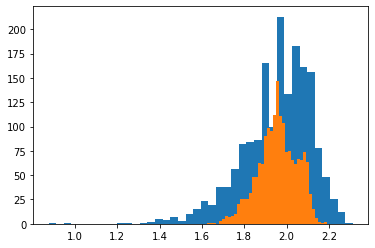

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')

(array([  2.,   4.,  17.,  34.,  53.,  64.,  70., 102.,  81.,  89.,  91.,
         84.,  74.,  73.,  76.,  55.,  56.,  51.,  48.,  41.,  26.,  30.,
         31.,  20.,  27.,  29.,  21.,  24.,  20.,  14.,  30.,  20.,  27.,
         24.,  31.,  22.,  27.,  52.,  45.,  69.]),
 array([ 8.904737 ,  9.151753 ,  9.398769 ,  9.645784 ,  9.8928   ,
        10.139816 , 10.386832 , 10.633848 , 10.880863 , 11.127879 ,
        11.374895 , 11.621911 , 11.868927 , 12.115942 , 12.362958 ,
        12.609974 , 12.85699  , 13.104006 , 13.351021 , 13.598037 ,
        13.845053 , 14.092069 , 14.339085 , 14.5861   , 14.833116 ,
        15.080132 , 15.3271475, 15.574163 , 15.821178 , 16.068195 ,
        16.31521  , 16.562225 , 16.809242 , 17.056257 , 17.303274 ,
        17.55029  , 17.797304 , 18.044321 , 18.291336 , 18.538353 ,
        18.785368 ], dtype=float32),
 <BarContainer object of 40 artists>)

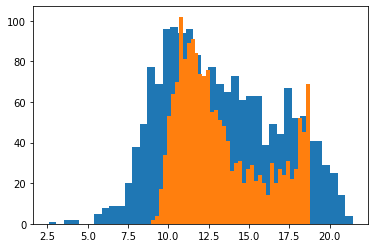

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')